# Convolutional Neural Networks

## Imports and constants

In [34]:
import torch
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchmetrics import Accuracy
from torchinfo import summary
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import os
import shutil
import subprocess
import webbrowser
import time
import matplotlib.pyplot as plt
import csv

import torch.nn.init as init
import numpy as np

import matplotlib.patches as mpatches
from sklearn.manifold import TSNE

import pandas as pd

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from torchvision.transforms.functional import to_pil_image




TENSORBOARD = False
EPOCHS = 10
models_path = 'models'
plots_path = 'graphs'
runs_path = 'runs'

## Load data & initial preprocessing

In [2]:
'''
#1 Download the FashionMNIST train and test datasets

#2 Compute the mean and std of train images

#3 Define transformations:
  -ToTensor: Converts images to tensors
  -Normalise: Normalizes images to have mean 0 and std 1

#4 Apply transforms to the train and test datasets
Train dataset:
  -RandomRotation: Randomly rotates the images only 10 degrees to add some variation without 
  changing significantly the uniformality of the dataset.
  -RandomHorizontalFlip: Randomly flips 20% of the images horizontally . . .
  -RandomResizedCrop: Randomly zooming into or cropping the images to help the model focus on different parts of the image.

#5 Split the train set into training and validation sets

#6 Create iterators for our datasets using DataLoader

#7 Select device for training. Selects GPU or MPS if available, otherwise uses CPU.

#8 Index dataset's labels to image descriptors
'''

#1
train_set_full = datasets.FashionMNIST( root='./datasets/', train=True, download=True, transform=transforms.ToTensor())
test_set = datasets.FashionMNIST(root='./datasets', train=False, download=True, transform=transforms.ToTensor())

#2
imgs = torch.stack([img for img, _ in train_set_full], dim=0)
mean = imgs.mean()
std = imgs.std()

#3
train_val_set_transforms_aug = transforms.Compose([
                                      #  transforms.ColorJitter(brightness=0.5),
                                       transforms.RandomRotation(degrees=10),
                                      #  transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                       #  transforms.RandomGrayscale(p=0.2),
                                       transforms.RandomResizedCrop(size=(28, 28), scale=(0.8, 1.0)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=mean, std=std)
                                      ]
                                      )

test_set_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=mean, std=std)
                                      ])

#4
train_val_dataset = datasets.FashionMNIST(root="./datasets/", train=True, download=True, transform=train_val_set_transforms_aug)
test_dataset = datasets.FashionMNIST(root="./datasets/", train=False, download=True, transform=test_set_transforms)


#5
train_size = int(0.8 * len(train_val_dataset))
validation_size = len(train_val_dataset) - train_size
train_set, validation_set = random_split(train_val_dataset, [train_size, validation_size])

#6
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

#7
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

#8
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

Using cpu device


In [3]:
# If tensorboard and there is a "runs" folder, delete it to start over
if TENSORBOARD:
    def delete_folder(folder_path):
        # Check if the folder exists
        if os.path.exists(folder_path) and os.path.isdir(folder_path):
            # Delete the folder
            shutil.rmtree(folder_path)
            print(f"Folder '{folder_path}' has been deleted.")
        else:
            print(f"Folder '{folder_path}' does not exist.")

    folder_to_delete = runs_path
    delete_folder(folder_to_delete)

In [4]:
# Decreasing learning rate function
def decrease_lr(model,rate):
    print(f"lr decreased from {rate}, to {rate/2}")
    return optim.Adam(model.parameters(), lr=rate/2)

## LENet baseline

### Define the LeNet model

In [5]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_wave = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),   # 28x28 -> 24x24
              nn.Tanh(),
              nn.AvgPool2d(kernel_size=2, stride=2),  # 24x24 -> 12x12
        )

        self.second_wave = nn.Sequential(      
              nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 12x12 -> 8x8
              nn.Tanh(),
              nn.AvgPool2d(kernel_size=2, stride=2),  # 8x8 -> 4x4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*4*4, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )
        
        # Initialize weights using Kaiming Uniform
        self._initialize_weights()
        
        # Additional output layers
        self.aux_output1 = nn.Linear(6 * 12 * 12, 10)  # After first pooling
        self.aux_output2 = nn.Linear(16 * 4 * 4, 10)   # After second pooling

    def forward(self, x):
        x = self.first_wave(x)
        aux1 = self.aux_output1(x.view(x.size(0), -1))
        
        x = self.second_wave(x)
        aux2 = self.aux_output2(x.view(x.size(0), -1))
        
        x = self.classifier(x)
        
        return x, aux1, aux2

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def get_features(self, x):
        # Pass through the first wave of layers
        x = self.first_wave(x)
        
        # Pass through the second wave of layers
        x = self.second_wave(x)
        
        # Flatten the output for the classifier
        x = x.view(x.size(0), -1)

        # Pass through all layers of the classifier except the last one
        for layer in self.classifier[:-1]:
            x = layer(x)

        return x


In [6]:
model_lenet5 = LeNet5()

summary(model=model_lenet5, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5 (LeNet5)                          [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (first_wave)                [1, 1, 28, 28]       [1, 6, 12, 12]       --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 24, 24]       156                  True
│    └─Tanh (1)                          [1, 6, 24, 24]       [1, 6, 24, 24]       --                   --
│    └─AvgPool2d (2)                     [1, 6, 24, 24]       [1, 6, 12, 12]       --                   --
├─Linear (aux_output1)                   [1, 864]             [1, 10]              8,650                True
├─Sequential (second_wave)               [1, 6, 12, 12]       [1, 16, 4, 4]        --                   True
│    └─Conv2d (0)                        [1, 6, 12, 12]       [1, 16, 8, 8]        2,416                True
│    └─Tanh (1)   

In [7]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss()
# Define Optimizer
optimizer = optim.Adam(model_lenet5.parameters(), lr=0.001)
# Define output accuracy function
accuracy = Accuracy(task='multiclass', num_classes=10)

### Train LeNet model

In [8]:
# Experiment tracking setup using TensorBoard
if TENSORBOARD:
    timestamp = datetime.now().strftime("%Y-%m-%d")
    experiment_name = "MNIST"
    model_name = "LeNet5"
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    writer = SummaryWriter(log_dir) # Initialize a TensorBoard writer for logging

    # Start TensorBoard using subprocess
    tensorboard_process = subprocess.Popen(["tensorboard", "--logdir", "runs", "--port", "6007"])

# Move accuracy and model to the appropriate device
accuracy = accuracy.to(device)
model_lenet5 = model_lenet5.to(device)

history_lenet5 = {'train_loss':[], 'val_loss':[], 'train_acc': [], 'val_acc': []}

EPOCHS = 12

epoch_count = 0

for epoch in tqdm(range(EPOCHS)): # Progress bar for epochs
    # Initialize trining loss and accuracy
    train_loss_v0, train_acc_v0 = 0.0, 0.0
    
    # Decrease the learning rate by 1/2
    if epoch_count%5 == 0 and epoch_count>0:
        optimizer = decrease_lr(model_lenet5, optimizer.defaults['lr'])
    
    epoch_count += 1
    
    # Iterating over batches of training data
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        # Set model to training mode
        model_lenet5.train()
        # Forward pass: compute predictions
        y_pred, _, _ = model_lenet5.forward(X)
        #Calculate the current batch loss and accuracy and aggregate it to the total variables
        loss = loss_fn(y_pred, y)
        train_loss_v0 += loss.item()
        acc = accuracy(y_pred, y)
        train_acc_v0 += acc
        # Zero out gradients
        optimizer.zero_grad()
        # Backpropagate the loss
        loss.backward()
        # Update model parameters
        optimizer.step()
        

    # Average training loss and accuracy over all batches
    train_loss_v0 /= len(train_loader)
    train_acc_v0 /= len(train_loader)
    # Keep history
    history_lenet5['train_loss'].append(train_loss_v0)
    history_lenet5['train_acc'].append(train_acc_v0)

    # Validation loop
    val_loss_v0, val_acc_v0 = 0.0, 0.0
    # Set model to evaluation mode
    model_lenet5.eval()
    with torch.inference_mode(): # Context manager for inference without gradient tracking
        for X, y in validation_loader:
            X, y = X.to(device), y.to(device)

            y_pred, _, _ = model_lenet5.forward(X)

            loss = loss_fn(y_pred, y)
            val_loss_v0 += loss.item()

            acc = accuracy(y_pred, y)
            val_acc_v0 += acc

        # Average validation loss and accuracy over all batches
        val_loss_v0 /= len(validation_loader)
        val_acc_v0 /= len(validation_loader)
        # Keep history
        history_lenet5['val_loss'].append(val_loss_v0)
        history_lenet5['val_acc'].append(val_acc_v0)

    if TENSORBOARD:
        # Log training and validation loss and accuracy to TensorBoard
        writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train/loss": train_loss_v0, "val/loss": val_loss_v0}, global_step=epoch)
        writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"train/acc": train_acc_v0, "val/acc": val_acc_v0}, global_step=epoch)

        if epoch == 0:
            # Optionally, open a web browser tab. The time delay allows TensorBoard to start up.
            time.sleep(3)  # Wait for 3 seconds before opening the browser
            webbrowser.open("http://localhost:6007")

    print(f"Epoch: {epoch}| Train loss: {train_loss_v0: .5f}| Train acc: {train_acc_v0: .5f}| Val loss: {val_loss_v0: .5f}| Val acc: {val_acc_v0: .5f}")

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.65946| Train acc:  0.75296| Val loss:  0.58193| Val acc:  0.78017
Epoch: 1| Train loss:  0.52139| Train acc:  0.80373| Val loss:  0.52138| Val acc:  0.80500
Epoch: 2| Train loss:  0.48419| Train acc:  0.81629| Val loss:  0.48897| Val acc:  0.81792
Epoch: 3| Train loss:  0.45741| Train acc:  0.82806| Val loss:  0.46933| Val acc:  0.82600
Epoch: 4| Train loss:  0.44444| Train acc:  0.83171| Val loss:  0.46033| Val acc:  0.82825
lr decreased from 0.001, to 0.0005
Epoch: 5| Train loss:  0.41070| Train acc:  0.84494| Val loss:  0.42959| Val acc:  0.84008
Epoch: 6| Train loss:  0.39751| Train acc:  0.84971| Val loss:  0.43304| Val acc:  0.83942
Epoch: 7| Train loss:  0.39031| Train acc:  0.85263| Val loss:  0.42599| Val acc:  0.84117
Epoch: 8| Train loss:  0.38502| Train acc:  0.85435| Val loss:  0.42576| Val acc:  0.83925
Epoch: 9| Train loss:  0.37798| Train acc:  0.85719| Val loss:  0.42688| Val acc:  0.84208
lr decreased from 0.0005, to 0.00025
Epoch: 10| Train l

### Visualize the descriptive layers

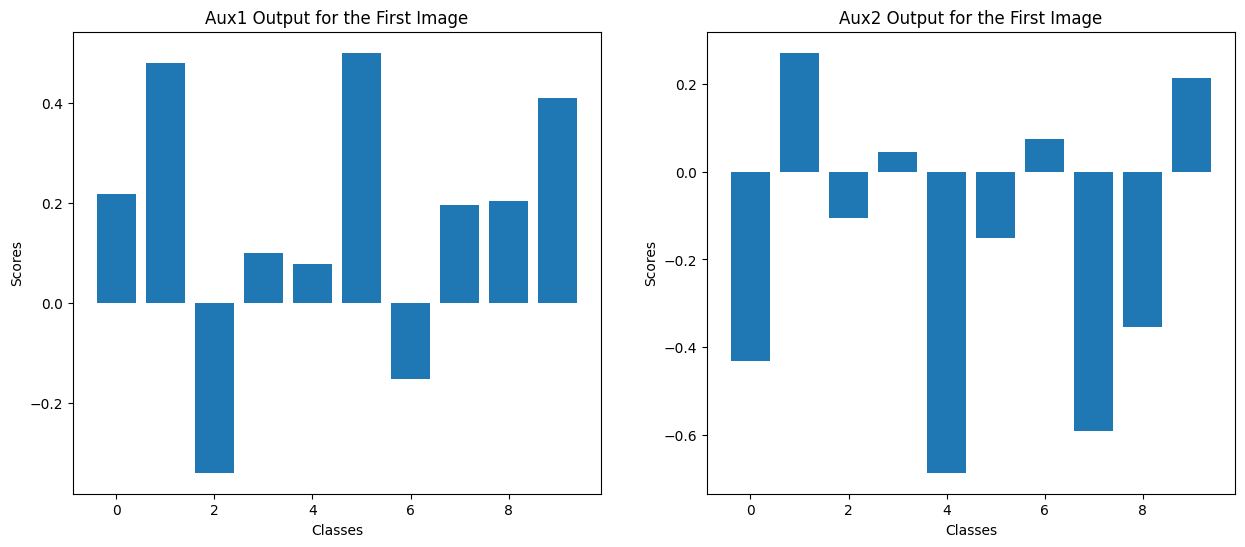

In [9]:
model_lenet5.eval()
with torch.no_grad():
    # Get one batch of data
    for images, _ in test_loader:
        images = images.to(device)
        _, aux1, aux2 = model_lenet5(images)

        # Select the first image in the batch for visualization
        scores_aux1 = aux1[0].cpu().numpy()
        scores_aux2 = aux2[0].cpu().numpy()

        # Plot
        plt.figure(figsize=(15, 6))
        
        plt.subplot(1, 2, 1)
        plt.title("Aux1 Output for the First Image")
        plt.bar(np.arange(10), scores_aux1)
        plt.xlabel('Classes')
        plt.ylabel('Scores')

        plt.subplot(1, 2, 2)
        plt.title("Aux2 Output for the First Image")
        plt.bar(np.arange(10), scores_aux2)
        plt.xlabel('Classes')
        plt.ylabel('Scores')

        plt.show()
        break  # Only visualize for the first batch


### Test in how many images the first Conv layer predicted the same as the second

In [10]:
total_samples = 0
matching_highest_scores = 0

model_lenet5.eval()
with torch.no_grad():
    for X, y in train_loader:
        X = X.to(device)
        _, aux1, aux2 = model_lenet5(X)

        # Get the indices of the max score for each sample in the batch
        max_indices_aux1 = torch.argmax(aux1, dim=1)
        max_indices_aux2 = torch.argmax(aux2, dim=1)

        # Count how many times the highest scoring classes match
        matches = torch.sum(max_indices_aux1 == max_indices_aux2)
        matching_highest_scores += matches.item()

        total_samples += X.size(0)

# Calculate the percentage
percentage_matching = (matching_highest_scores / total_samples) * 100
print(f"Percentage of matching highest scores: {percentage_matching:.2f}%")


Percentage of matching highest scores: 9.80%


### t-SNE visualization

c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


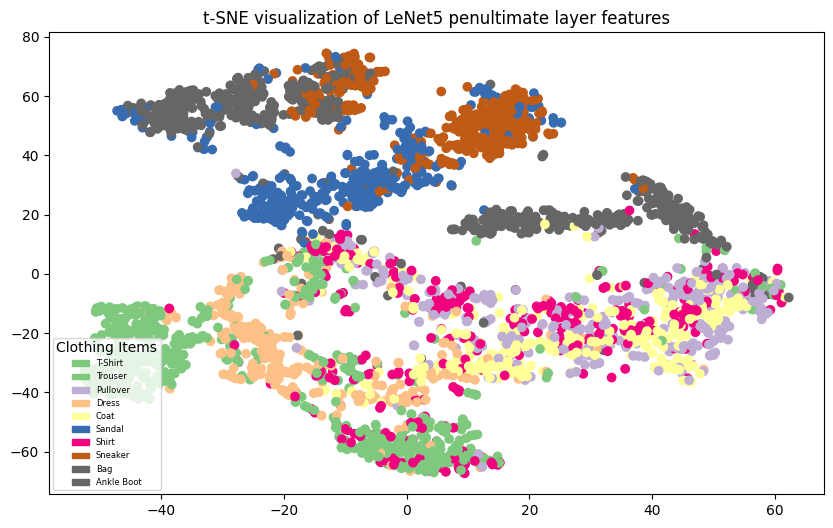

In [97]:
features = []
labels_list = []

model_lenet5.eval()
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        feature = model_lenet5.get_features(X)
        features.append(feature.cpu().numpy())
        labels_list.append(y.numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels_list, axis=0)

features = features[::3]
labels = labels[::3]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=123).fit_transform(features)

# Create a color map with distinct colors for each label
cmap = plt.cm.get_cmap('Accent', 10) 

# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap=cmap)
plt.title("t-SNE visualization of LeNet5 penultimate layer features")

# Create a legend
handles = [mpatches.Patch(color=cmap(i), label=labels_map[i]) for i in range(10)]
plt.legend(handles=handles, title="Clothing Items", fontsize="6", loc="lower left")

plt.show()


In [117]:
def get_image_for_label(label, dataset):
    for image, image_label in dataset:
        if image_label == label:
            # Convert the PyTorch tensor to a PIL image
            image = to_pil_image(image)
            return image
    return None

c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\chris\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


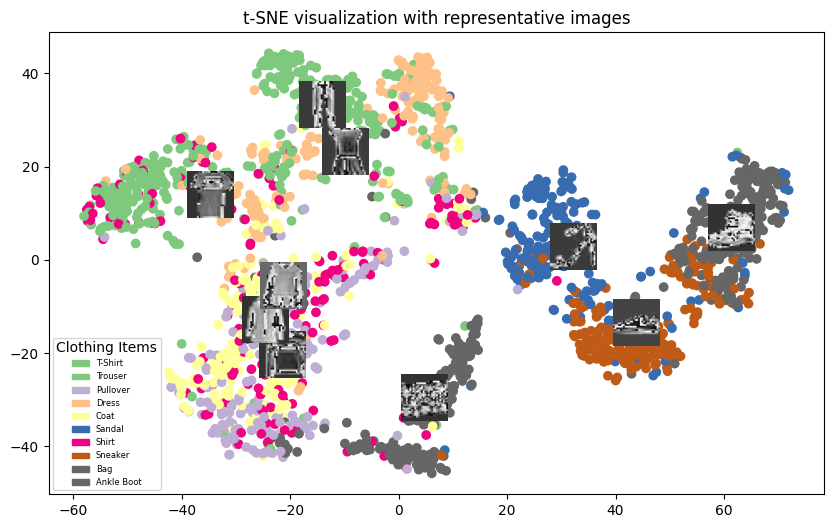

In [119]:
features = []
labels_list = []

model_lenet5.eval()
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        feature = model_lenet5.get_features(X)
        features.append(feature.cpu().numpy())
        labels_list.append(y.numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels_list, axis=0)

features = features[::5]
labels = labels[::5]

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=123).fit_transform(features)

# Create a color map with distinct colors for each label
cmap = plt.cm.get_cmap('Accent', 10) 



# Find centroids of each class in the t-SNE space
centroids = {label: np.mean(tsne[labels == label], axis=0) for label in range(10)}

# Prepare to overlay images
representative_images = {label: get_image_for_label(label, train_val_dataset) for label in range(10)}

# Plot t-SNE and overlay images
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap=cmap)

for label, centroid in centroids.items():
    image = representative_images[label]
    if image is not None:
        # Increase the zoom factor to make images larger
        imagebox = OffsetImage(image, zoom=1.2, cmap='gray')  # Adjust zoom as needed
        ab = AnnotationBbox(imagebox, centroid, frameon=False)
        ax.add_artist(ab)

# Add legend and display the plot
handles = [mpatches.Patch(color=cmap(i), label=labels_map[i]) for i in range(10)]
plt.legend(handles=handles, title="Clothing Items", fontsize="6", loc="lower left")
plt.title("t-SNE visualization with representative images")
plt.show()

In [13]:
def plot_train_val_metrics(history, model_name):
    plt.figure(figsize=(10, 4))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss', color='black')
    plt.plot(history['val_loss'], label='Validation Loss', color='red')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy', color='black')
    plt.plot(history['val_acc'], label='Validation Accuracy', color='red')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Add a main title for the whole figure
    plt.suptitle(f"Training and Validation Metrics for {model_name}", fontsize=16, y=1.05)

    # Adjust layout and show plot
    plt.tight_layout()
    
    # Save plot to file
    save_path = os.path.join(plots_path +'/', f"{model_name}_metrics.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    
    plt.show()


In [13]:
def export_model(model, model_filename):
    model_scripted = torch.jit.script(model)  # Export to TorchScript
    save_path = os.path.join(models_path, model_filename + '.pt')
    model_scripted.save(save_path)  # Save the model

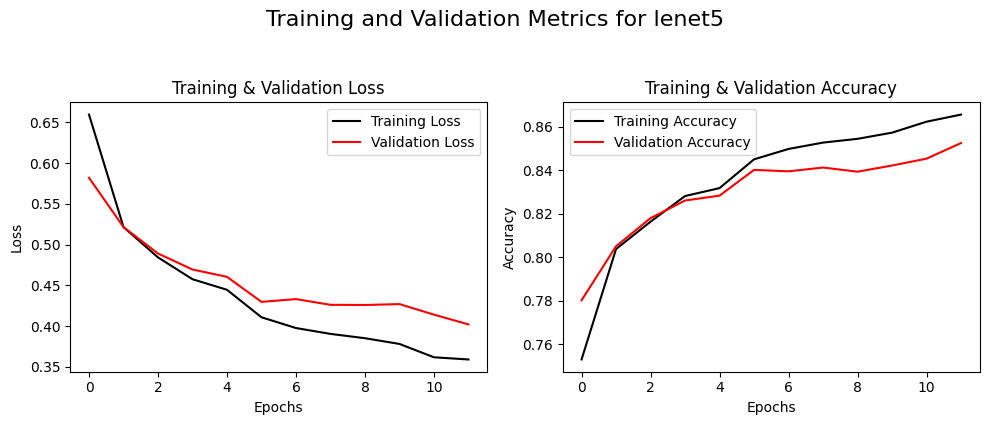

In [14]:
plot_train_val_metrics(history_lenet5, "lenet5")

In [15]:
export_model(model_lenet5, 'lenet5_model_original')

### Evaluation on the test set

In [17]:
test_loss, test_acc = 0, 0
# Same procedure with the validation set
model_lenet5.eval()
with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred, _, _ = model_lenet5(X)

        test_loss += loss_fn(y_pred, y)
        test_acc += accuracy(y_pred, y)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

print(f"Test loss: {test_loss: .5f}| Test acc: {test_acc: .5f}")

Test loss:  0.32846| Test acc:  0.87849


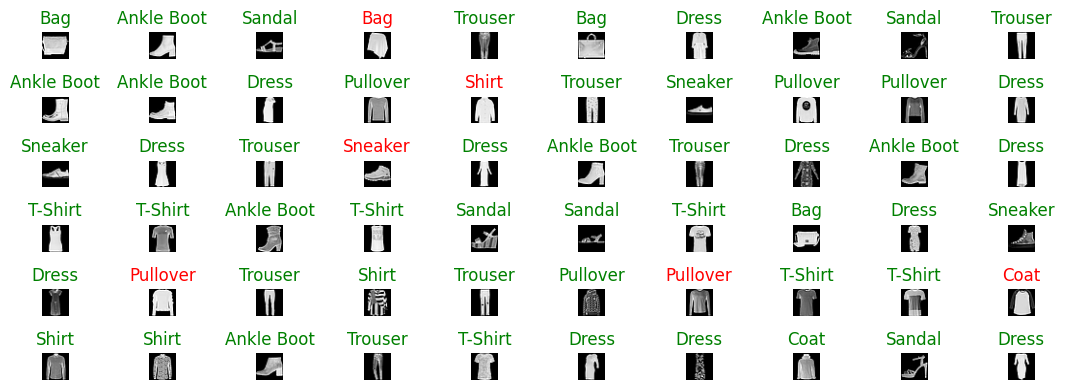

In [48]:
# See random images with their labels
torch.manual_seed(22)  # setting random seed
%matplotlib inline
fig = plt.figure(figsize=(12, 4))

rows, cols = 6, 10
for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(test_dataset), size=[1]).item()
    img, label_gt = test_dataset[random_idx]
    img_temp = img.unsqueeze(dim=0).to(device)
    # print(img.shape)
    label_pred = int(torch.argmax(model_lenet5(img_temp)[0]))
    fig.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)    # CWH --> WHC
    plt.imshow(img, cmap='gray')
    if label_pred == label_gt:
        plt.title(labels_map[label_pred], color='g') # green label for correct prediction
    else:
        plt.title(labels_map[label_pred], color='r') # red label for incorrect prediction
    plt.axis(False)
    plt.tight_layout();

## Model variants

### 1st variant
Replace Tanh with ReLu

In [19]:
class LeNet5_v1(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_wave = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),   # 28x28 -> 24x24
              nn.ReLU(),
              nn.AvgPool2d(kernel_size=2, stride=2),  # 24x24 -> 12x12
        )

        self.second_wave = nn.Sequential(      
              nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 12x12 -> 8x8
              nn.ReLU(),
              nn.AvgPool2d(kernel_size=2, stride=2),  # 8x8 -> 4x4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*4*4, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )
        
        # Initialize weights using Kaiming Uniform
        self._initialize_weights()
        
        # Additional output layers
        self.aux_output1 = nn.Linear(6 * 12 * 12, 10)  # After first pooling
        self.aux_output2 = nn.Linear(16 * 4 * 4, 10)   # After second pooling

    def forward(self, x):
        x = self.first_wave(x)
        aux1 = self.aux_output1(x.view(x.size(0), -1))
        
        x = self.second_wave(x)
        aux2 = self.aux_output2(x.view(x.size(0), -1))
        
        x = self.classifier(x)
        
        return x, aux1, aux2

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def get_features(self, x):
        # Pass through the first wave of layers
        x = self.first_wave(x)
        
        # Pass through the second wave of layers
        x = self.second_wave(x)
        
        # Flatten the output for the classifier
        x = x.view(x.size(0), -1)

        # Pass through all layers of the classifier except the last one
        for layer in self.classifier[:-1]:
            x = layer(x)

        return x


In [20]:
model_lenet5_v1 = LeNet5_v1()

summary(model=model_lenet5_v1, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5_v1 (LeNet5_v1)                    [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (first_wave)                [1, 1, 28, 28]       [1, 6, 12, 12]       --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 24, 24]       156                  True
│    └─ReLU (1)                          [1, 6, 24, 24]       [1, 6, 24, 24]       --                   --
│    └─AvgPool2d (2)                     [1, 6, 24, 24]       [1, 6, 12, 12]       --                   --
├─Linear (aux_output1)                   [1, 864]             [1, 10]              8,650                True
├─Sequential (second_wave)               [1, 6, 12, 12]       [1, 16, 4, 4]        --                   True
│    └─Conv2d (0)                        [1, 6, 12, 12]       [1, 16, 8, 8]        2,416                True
│    └─ReLU (1)   

In [21]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss()
# Define Optimizer
optimizer = optim.Adam(model_lenet5_v1.parameters(), lr=0.001)
# Define output accuracy function
accuracy = Accuracy(task='multiclass', num_classes=10)

In [22]:
# Experiment tracking setup using TensorBoard
if TENSORBOARD:
    timestamp = datetime.now().strftime("%Y-%m-%d")
    experiment_name = "MNIST"
    model_name = "LeNet5_v1"
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    writer_v1 = SummaryWriter(log_dir) # Initialize a TensorBoard writer for logging

# Move accuracy and model to the appropriate device
accuracy = accuracy.to(device)
model_lenet5_v1 = model_lenet5_v1.to(device)

history_lenet5_v1 = {'train_loss':[], 'val_loss':[], 'train_acc': [], 'val_acc': []}

EPOCHS = 12

epoch_count = 0

for epoch in tqdm(range(EPOCHS)): # Progress bar for epochs
    # Initialize trining loss and accuracy
    train_loss_v1, train_acc_v1 = 0.0, 0.0
    
    # Decrease the learning rate by 1/2
    if epoch_count%5 == 0 and epoch_count>0:
        optimizer = decrease_lr(model_lenet5, optimizer.defaults['lr'])
    
    epoch_count += 1

    # Iterating over batches of training data
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        # Set model to training mode
        model_lenet5_v1.train()
        # Forward pass: compute predictions
        y_pred, _, _ = model_lenet5_v1(X)
        #Calculate the current batch loss and accuracy and aggregate it to the total variables
        loss = loss_fn(y_pred, y)
        train_loss_v1 += loss.item()
        acc = accuracy(y_pred, y)
        train_acc_v1 += acc
        # Zero out gradients
        optimizer.zero_grad()
        # Backpropagate the loss
        loss.backward()
        # Update model parameters
        optimizer.step()

    # Average training loss and accuracy over all batches
    train_loss_v1 /= len(train_loader)
    train_acc_v1 /= len(train_loader)
    # Keep history
    history_lenet5_v1['train_loss'].append(train_loss_v1)
    history_lenet5_v1['train_acc'].append(train_acc_v1)

    # Validation loop
    val_loss_v1, val_acc_v1 = 0.0, 0.0
    # Set model to evaluation mode
    model_lenet5_v1.eval()
    with torch.inference_mode(): # Context manager for inference without gradient tracking
        for X, y in validation_loader:
            X, y = X.to(device), y.to(device)

            y_pred, _, _ = model_lenet5_v1(X)

            loss = loss_fn(y_pred, y)
            val_loss_v1 += loss.item()

            acc = accuracy(y_pred, y)
            val_acc_v1 += acc

        # Average validation loss and accuracy over all batches
        val_loss_v1 /= len(validation_loader)
        val_acc_v1 /= len(validation_loader)
        # Keep history
        history_lenet5_v1['val_loss'].append(val_loss_v1)
        history_lenet5_v1['val_acc'].append(val_acc_v1)

    if TENSORBOARD:
        # Log training and validation loss and accuracy to TensorBoard
        writer_v1.add_scalars(main_tag="Loss_v1", tag_scalar_dict={"train_v1/loss_v1": train_loss_v1, "val_v1/loss_v1": val_loss_v1}, global_step=epoch)
        writer_v1.add_scalars(main_tag="Accuracy_v1", tag_scalar_dict={"train_v1/acc_v1": train_acc_v1, "val_v1/acc_v1": val_acc_v1}, global_step=epoch)

    print(f"Epoch: {epoch}| Train loss: {train_loss_v1: .5f}| Train acc: {train_acc_v1: .5f}| Val loss: {val_loss_v1: .5f}| Val acc: {val_acc_v1: .5f}")

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.68920| Train acc:  0.73969| Val loss:  0.58921| Val acc:  0.77758
Epoch: 1| Train loss:  0.53581| Train acc:  0.79356| Val loss:  0.56039| Val acc:  0.79100
Epoch: 2| Train loss:  0.49022| Train acc:  0.81490| Val loss:  0.51232| Val acc:  0.81183
Epoch: 3| Train loss:  0.46214| Train acc:  0.82640| Val loss:  0.46728| Val acc:  0.82958
Epoch: 4| Train loss:  0.43359| Train acc:  0.83637| Val loss:  0.45667| Val acc:  0.83033
lr decreased from 0.001, to 0.0005
Epoch: 5| Train loss:  0.41550| Train acc:  0.84277| Val loss:  0.45705| Val acc:  0.82850
Epoch: 6| Train loss:  0.41973| Train acc:  0.84042| Val loss:  0.45732| Val acc:  0.83108
Epoch: 7| Train loss:  0.41808| Train acc:  0.84167| Val loss:  0.44917| Val acc:  0.82975
Epoch: 8| Train loss:  0.41900| Train acc:  0.84258| Val loss:  0.44824| Val acc:  0.83317
Epoch: 9| Train loss:  0.41927| Train acc:  0.84035| Val loss:  0.45636| Val acc:  0.82808
lr decreased from 0.0005, to 0.00025
Epoch: 10| Train l

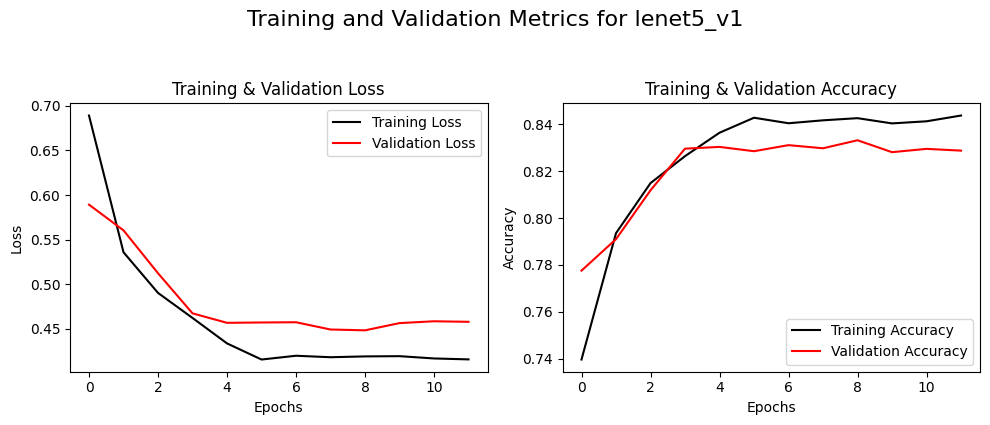

In [23]:
plot_train_val_metrics(history_lenet5_v1, "lenet5_v1")

In [24]:
export_model(model_lenet5_v1, 'lenet5_model_v1')

### 2nd variant
Add dropout layers

In [8]:
class LeNet5_v2(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_wave = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),   # 28x28 -> 24x24
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),  # 24x24 -> 12x12
        )

        self.second_wave = nn.Sequential(      
              nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 12x12 -> 8x8
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),  # 8x8 -> 4x4
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*4*4, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )
        
        # Initialize weights using Kaiming Uniform
        self._initialize_weights()
        
        # Additional output layers
        self.aux_output1 = nn.Linear(6 * 12 * 12, 10)  # After first pooling
        self.aux_output2 = nn.Linear(16 * 4 * 4, 10)   # After second pooling

    def forward(self, x):
        x = self.first_wave(x)
        aux1 = self.aux_output1(x.view(x.size(0), -1))
        
        x = self.second_wave(x)
        aux2 = self.aux_output2(x.view(x.size(0), -1))
        
        x = self.classifier(x)
        
        return x, aux1, aux2

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def get_features(self, x):
        # Pass through the first wave of layers
        x = self.first_wave(x)
        
        # Pass through the second wave of layers
        x = self.second_wave(x)
        
        # Flatten the output for the classifier
        x = x.view(x.size(0), -1)

        # Pass through all layers of the classifier except the last one
        for layer in self.classifier[:-1]:
            x = layer(x)

        return x


In [9]:
model_lenet5_v2 = LeNet5_v2()

summary(model=model_lenet5_v2, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5_v2 (LeNet5_v2)                    [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (first_wave)                [1, 1, 28, 28]       [1, 6, 12, 12]       --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 6, 24, 24]       156                  True
│    └─ReLU (1)                          [1, 6, 24, 24]       [1, 6, 24, 24]       --                   --
│    └─MaxPool2d (2)                     [1, 6, 24, 24]       [1, 6, 12, 12]       --                   --
├─Linear (aux_output1)                   [1, 864]             [1, 10]              8,650                True
├─Sequential (second_wave)               [1, 6, 12, 12]       [1, 16, 4, 4]        --                   True
│    └─Conv2d (0)                        [1, 6, 12, 12]       [1, 16, 8, 8]        2,416                True
│    └─ReLU (1)   

In [10]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss()
# Define Optimizer
optimizer = optim.Adam(model_lenet5_v2.parameters(), lr=0.001)
# Define output accuracy function
accuracy = Accuracy(task='multiclass', num_classes=10)

In [11]:
# Experiment tracking setup using TensorBoard
if TENSORBOARD:
    timestamp = datetime.now().strftime("%Y-%m-%d")
    experiment_name = "MNIST"
    model_name = "LeNet5_v2"
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    writer_v2 = SummaryWriter(log_dir) # Initialize a TensorBoard writer for logging

# Move accuracy and model to the appropriate device
accuracy = accuracy.to(device)
model_lenet5_v2 = model_lenet5_v2.to(device)

history_lenet5_v2 = {'train_loss':[], 'val_loss':[], 'train_acc': [], 'val_acc': []}

EPOCHS = 12

epoch_count = 0

for epoch in tqdm(range(EPOCHS)): # Progress bar for epochs
    # Initialize trining loss and accuracy
    train_loss_v2, train_acc_v2 = 0.0, 0.0
    
    # Decrease the learning rate by 1/2
    if epoch_count%5 == 0 and epoch_count>0:
        optimizer = decrease_lr(model_lenet5, optimizer.defaults['lr'])
    
    epoch_count += 1

    # Iterating over batches of training data
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        # Set model to training mode
        model_lenet5_v2.train()
        # Forward pass: compute predictions
        y_pred, _, _ = model_lenet5_v2(X)
        #Calculate the current batch loss and accuracy and aggregate it to the total variables
        loss = loss_fn(y_pred, y)
        train_loss_v2 += loss.item()
        acc = accuracy(y_pred, y)
        train_acc_v2 += acc
        # Zero out gradients
        optimizer.zero_grad()
        # Backpropagate the loss
        loss.backward()
        # Update model parameters
        optimizer.step()

    # Average training loss and accuracy over all batches
    train_loss_v2 /= len(train_loader)
    train_acc_v2 /= len(train_loader)
    # Keep history
    history_lenet5_v2['train_loss'].append(train_loss_v2)
    history_lenet5_v2['train_acc'].append(train_acc_v2)

    # Validation loop
    val_loss_v2, val_acc_v2 = 0.0, 0.0
    # Set model to evaluation mode
    model_lenet5_v2.eval()
    with torch.inference_mode(): # Context manager for inference without gradient tracking
        for X, y in validation_loader:
            X, y = X.to(device), y.to(device)

            y_pred, _, _ = model_lenet5_v2(X)

            loss = loss_fn(y_pred, y)
            val_loss_v2 += loss.item()

            acc = accuracy(y_pred, y)
            val_acc_v2 += acc

        # Average validation loss and accuracy over all batches
        val_loss_v2 /= len(validation_loader)
        val_acc_v2 /= len(validation_loader)
        # Keep history
        history_lenet5_v2['val_loss'].append(val_loss_v2)
        history_lenet5_v2['val_acc'].append(val_acc_v2)

    if TENSORBOARD:
        # Log training and validation loss and accuracy to TensorBoard
        writer_v2.add_scalars(main_tag="Loss_v2", tag_scalar_dict={"train_v2/loss_v2": train_loss_v2, "val_v2/loss_v2": val_loss_v2}, global_step=epoch)
        writer_v2.add_scalars(main_tag="Accuracy_v2", tag_scalar_dict={"train_v2/acc_v24": train_acc_v2, "val_v2/acc_v2": val_acc_v2}, global_step=epoch)

    print(f"Epoch: {epoch}| Train loss: {train_loss_v2: .5f}| Train acc: {train_acc_v2: .5f}| Val loss: {val_loss_v2: .5f}| Val acc: {val_acc_v2: .5f}")

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.65166| Train acc:  0.75725| Val loss:  0.52697| Val acc:  0.80700
Epoch: 1| Train loss:  0.49935| Train acc:  0.81456| Val loss:  0.46693| Val acc:  0.82525
Epoch: 2| Train loss:  0.45050| Train acc:  0.83204| Val loss:  0.46993| Val acc:  0.82700
Epoch: 3| Train loss:  0.42665| Train acc:  0.84135| Val loss:  0.43627| Val acc:  0.83758
Epoch: 4| Train loss:  0.41152| Train acc:  0.84600| Val loss:  0.41884| Val acc:  0.84375
lr decreased from 0.001, to 0.0005
Epoch: 5| Train loss:  0.40197| Train acc:  0.84779| Val loss:  0.41888| Val acc:  0.84175
Epoch: 6| Train loss:  0.39928| Train acc:  0.84833| Val loss:  0.42044| Val acc:  0.83908
Epoch: 7| Train loss:  0.40307| Train acc:  0.84983| Val loss:  0.41636| Val acc:  0.84492
Epoch: 8| Train loss:  0.39875| Train acc:  0.84823| Val loss:  0.42383| Val acc:  0.83842
Epoch: 9| Train loss:  0.40060| Train acc:  0.84994| Val loss:  0.41819| Val acc:  0.84208
lr decreased from 0.0005, to 0.00025
Epoch: 10| Train l

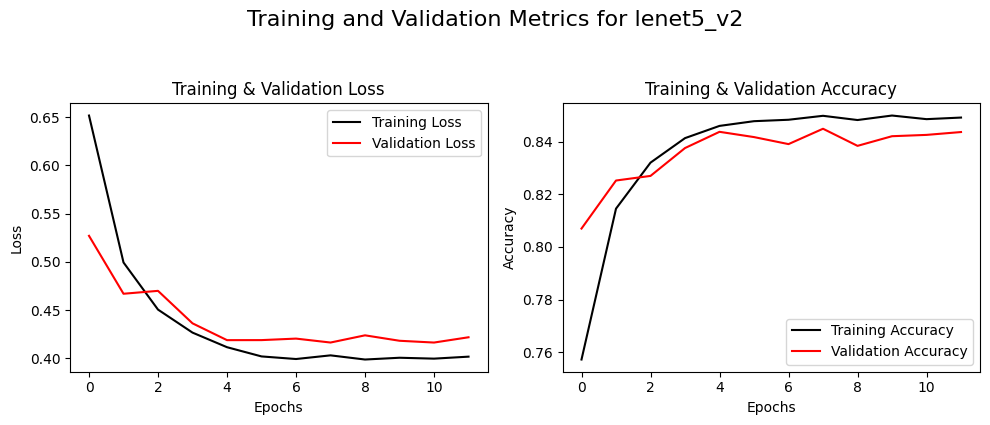

In [14]:
plot_train_val_metrics(history_lenet5_v2, "lenet5_v2")

In [30]:
export_model(model_lenet5_v2, 'lenet5_model_v2')

### 3rd variant
Modify convolutional layers

In [19]:
class LeNet5_v3(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_wave = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1),   # 28x28 -> 24x24
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),    #24x24 -> 12x12
        )

        self.second_wave = nn.Sequential(      
              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),  # 12x12 -> 10x10
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2)     # 10x10 -> 5x5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64*5*5, out_features=240),
            nn.ReLU(),
            nn.Linear(in_features=240, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=10),
        )
        
        # Initialize weights using Kaiming Uniform
        self._initialize_weights()
        
        # Additional output layers
        self.aux_output1 = nn.Linear(32 * 12 * 12, 10)  # After first pooling
        self.aux_output2 = nn.Linear(64 * 5 * 5, 10)   # After second pooling

    def forward(self, x):
        x = self.first_wave(x)
        aux1 = self.aux_output1(x.view(x.size(0), -1))
        
        x = self.second_wave(x)
        aux2 = self.aux_output2(x.view(x.size(0), -1))
        
        x = self.classifier(x)
        
        return x, aux1, aux2

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def get_features(self, x):
        # Pass through the first wave of layers
        x = self.first_wave(x)
        
        # Pass through the second wave of layers
        x = self.second_wave(x)
        
        # Flatten the output for the classifier
        x = x.view(x.size(0), -1)

        # Pass through all layers of the classifier except the last one
        for layer in self.classifier[:-1]:
            x = layer(x)

        return x


In [20]:
model_lenet5_v3 = LeNet5_v3()

summary(model=model_lenet5_v3, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5_v3 (LeNet5_v3)                    [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (first_wave)                [1, 1, 28, 28]       [1, 32, 12, 12]      --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 32, 24, 24]      832                  True
│    └─ReLU (1)                          [1, 32, 24, 24]      [1, 32, 24, 24]      --                   --
│    └─MaxPool2d (2)                     [1, 32, 24, 24]      [1, 32, 12, 12]      --                   --
├─Linear (aux_output1)                   [1, 4608]            [1, 10]              46,090               True
├─Sequential (second_wave)               [1, 32, 12, 12]      [1, 64, 5, 5]        --                   True
│    └─Conv2d (0)                        [1, 32, 12, 12]      [1, 64, 10, 10]      18,496               True
│    └─ReLU (1)   

In [21]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss()
# Define Optimizer
optimizer = optim.Adam(model_lenet5_v3.parameters(), lr=0.001)
# Define output accuracy function
accuracy = Accuracy(task='multiclass', num_classes=10)

In [22]:
# Experiment tracking setup using TensorBoard
if TENSORBOARD:
    timestamp = datetime.now().strftime("%Y-%m-%d")
    experiment_name = "MNIST"
    model_name = "LeNet5_v3"
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    writer_v3 = SummaryWriter(log_dir) # Initialize a TensorBoard writer for logging

# Move accuracy and model to the appropriate device
accuracy = accuracy.to(device)
model_lenet5_v3 = model_lenet5_v3.to(device)

history_lenet5_v3 = {'train_loss':[], 'val_loss':[], 'train_acc': [], 'val_acc': []}

EPOCHS = 12

epoch_count = 0

for epoch in tqdm(range(EPOCHS)): # Progress bar for epochs
    # Initialize trining loss and accuracy
    train_loss_v3, train_acc_v3 = 0.0, 0.0
    
    # Decrease the learning rate by 1/2
    if epoch_count%5 == 0 and epoch_count>0:
        optimizer = decrease_lr(model_lenet5, optimizer.defaults['lr'])
    
    epoch_count += 1

    # Iterating over batches of training data
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        # Set model to training mode
        model_lenet5_v3.train()
        # Forward pass: compute predictions
        y_pred, _, _ = model_lenet5_v3(X)
        #Calculate the current batch loss and accuracy and aggregate it to the total variables
        loss = loss_fn(y_pred, y)
        train_loss_v3 += loss.item()
        acc = accuracy(y_pred, y)
        train_acc_v3 += acc
        # Zero out gradients
        optimizer.zero_grad()
        # Backpropagate the loss
        loss.backward()
        # Update model parameters
        optimizer.step()

    # Average training loss and accuracy over all batches
    train_loss_v3 /= len(train_loader)
    train_acc_v3 /= len(train_loader)
    # Keep history
    history_lenet5_v3['train_loss'].append(train_loss_v3)
    history_lenet5_v3['train_acc'].append(train_acc_v3)

    # Validation loop
    val_loss_v3, val_acc_v3 = 0.0, 0.0
    # Set model to evaluation mode
    model_lenet5_v3.eval()
    with torch.inference_mode(): # Context manager for inference without gradient tracking
        for X, y in validation_loader:
            X, y = X.to(device), y.to(device)

            y_pred, _, _ = model_lenet5_v3(X)

            loss = loss_fn(y_pred, y)
            val_loss_v3 += loss.item()

            acc = accuracy(y_pred, y)
            val_acc_v3 += acc

        # Average validation loss and accuracy over all batches
        val_loss_v3 /= len(validation_loader)
        val_acc_v3 /= len(validation_loader)
        # Keep history
        history_lenet5_v3['val_loss'].append(val_loss_v3)
        history_lenet5_v3['val_acc'].append(val_acc_v3)

    if TENSORBOARD:
        # Log training and validation loss and accuracy to TensorBoard
        writer_v3.add_scalars(main_tag="Loss_v3", tag_scalar_dict={"train_v3/loss_v3": train_loss_v3, "val_v3/loss_v3": val_loss_v3}, global_step=epoch)
        writer_v3.add_scalars(main_tag="Accuracy_v3", tag_scalar_dict={"train_v3/acc_v3": train_acc_v3, "val_v3/acc_v3": val_acc_v3}, global_step=epoch)

    print(f"Epoch: {epoch}| Train loss: {train_loss_v3: .5f}| Train acc: {train_acc_v3: .5f}| Val loss: {val_loss_v3: .5f}| Val acc: {val_acc_v3: .5f}")

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.56919| Train acc:  0.78723| Val loss:  0.46733| Val acc:  0.82850
Epoch: 1| Train loss:  0.41862| Train acc:  0.84296| Val loss:  0.41688| Val acc:  0.84417
Epoch: 2| Train loss:  0.38106| Train acc:  0.85717| Val loss:  0.40543| Val acc:  0.84892
Epoch: 3| Train loss:  0.35482| Train acc:  0.86777| Val loss:  0.38159| Val acc:  0.85817
Epoch: 4| Train loss:  0.33953| Train acc:  0.87413| Val loss:  0.35165| Val acc:  0.86917
lr decreased from 0.001, to 0.0005
Epoch: 5| Train loss:  0.32942| Train acc:  0.87396| Val loss:  0.35148| Val acc:  0.86525
Epoch: 6| Train loss:  0.32696| Train acc:  0.87629| Val loss:  0.35631| Val acc:  0.86633
Epoch: 7| Train loss:  0.32639| Train acc:  0.87596| Val loss:  0.36151| Val acc:  0.86433
Epoch: 8| Train loss:  0.32545| Train acc:  0.87719| Val loss:  0.35599| Val acc:  0.86358
Epoch: 9| Train loss:  0.32478| Train acc:  0.87544| Val loss:  0.35415| Val acc:  0.86975
lr decreased from 0.0005, to 0.00025
Epoch: 10| Train l

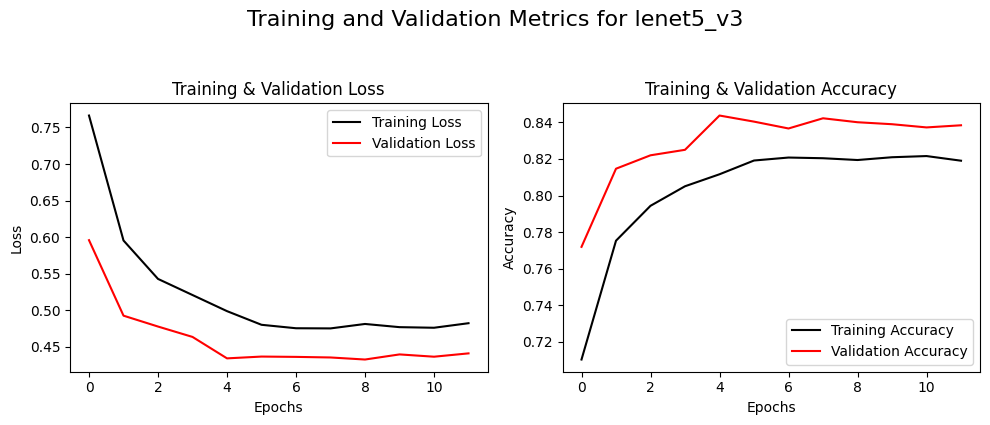

In [35]:
plot_train_val_metrics(history_lenet5_v3, "lenet5_v3")

In [36]:
export_model(model_lenet5_v3, 'lenet5_model_v3')

### 4th variant
L2 regularization

In [24]:
class LeNet5_v4(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_wave = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1),   # 28x28 -> 24x24
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2),    #24x24 -> 12x12
        )

        self.second_wave = nn.Sequential(      
              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1),  # 12x12 -> 10x10
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2, stride=2)     # 10x10 -> 5x5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=64*5*5, out_features=240),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=240, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=10),
        )
        
        # Initialize weights using Kaiming Uniform
        self._initialize_weights()
        
        # Additional output layers
        self.aux_output1 = nn.Linear(32 * 12 * 12, 10)  # After first pooling
        self.aux_output2 = nn.Linear(64 * 5 * 5, 10)   # After second pooling

    def forward(self, x):
        x = self.first_wave(x)
        aux1 = self.aux_output1(x.view(x.size(0), -1))
        
        x = self.second_wave(x)
        aux2 = self.aux_output2(x.view(x.size(0), -1))
        
        x = self.classifier(x)
        
        return x, aux1, aux2

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def get_features(self, x):
        # Pass through the first wave of layers
        x = self.first_wave(x)
        
        # Pass through the second wave of layers
        x = self.second_wave(x)
        
        # Flatten the output for the classifier
        x = x.view(x.size(0), -1)

        # Pass through all layers of the classifier except the last one
        for layer in self.classifier[:-1]:
            x = layer(x)

        return x


In [25]:
model_lenet5_v4 = LeNet5_v4()

summary(model=model_lenet5_v4, input_size=(1, 1, 28, 28), col_width=20,
                  col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5_v4 (LeNet5_v4)                    [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (first_wave)                [1, 1, 28, 28]       [1, 32, 12, 12]      --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 32, 24, 24]      832                  True
│    └─ReLU (1)                          [1, 32, 24, 24]      [1, 32, 24, 24]      --                   --
│    └─MaxPool2d (2)                     [1, 32, 24, 24]      [1, 32, 12, 12]      --                   --
├─Linear (aux_output1)                   [1, 4608]            [1, 10]              46,090               True
├─Sequential (second_wave)               [1, 32, 12, 12]      [1, 64, 5, 5]        --                   True
│    └─Conv2d (0)                        [1, 32, 12, 12]      [1, 64, 10, 10]      18,496               True
│    └─ReLU (1)   

In [26]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss()
# Define Optimizer
optimizer = optim.Adam(model_lenet5_v4.parameters(), lr=0.001, weight_decay=1e-4)
# Define output accuracy function
accuracy = Accuracy(task='multiclass', num_classes=10)

In [27]:
# Experiment tracking setup using TensorBoard
if TENSORBOARD:
    timestamp = datetime.now().strftime("%Y-%m-%d")
    experiment_name = "MNIST"
    model_name = "LeNet5_v4"
    log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    writer_v4 = SummaryWriter(log_dir) # Initialize a TensorBoard writer for logging

# Move accuracy and model to the appropriate device
accuracy = accuracy.to(device)
model_lenet5_v4 = model_lenet5_v4.to(device)

history_lenet5_v4 = {'train_loss':[], 'val_loss':[], 'train_acc': [], 'val_acc': []}

EPOCHS = 12

epoch_count = 0

for epoch in tqdm(range(EPOCHS)): # Progress bar for epochs
    # Initialize trining loss and accuracy
    train_loss_v4, train_acc_v4 = 0.0, 0.0
    
    # Decrease the learning rate by 1/2
    if epoch_count%5 == 0 and epoch_count>0:
        optimizer = decrease_lr(model_lenet5, optimizer.defaults['lr'])
    
    epoch_count += 1

    # Iterating over batches of training data
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        # Set model to training mode
        model_lenet5_v4.train()
        # Forward pass: compute predictions
        y_pred, _, _ = model_lenet5_v4(X)
        #Calculate the current batch loss and accuracy and aggregate it to the total variables
        loss = loss_fn(y_pred, y)
        train_loss_v4 += loss.item()
        acc = accuracy(y_pred, y)
        train_acc_v4 += acc
        # Zero out gradients
        optimizer.zero_grad()
        # Backpropagate the loss
        loss.backward()
        # Update model parameters
        optimizer.step()

    # Average training loss and accuracy over all batches
    train_loss_v4 /= len(train_loader)
    train_acc_v4 /= len(train_loader)
    # Keep history
    history_lenet5_v4['train_loss'].append(train_loss_v4)
    history_lenet5_v4['train_acc'].append(train_acc_v4)

    # Validation loop
    val_loss_v4, val_acc_v4 = 0.0, 0.0
    # Set model to evaluation mode
    model_lenet5_v4.eval()
    with torch.inference_mode(): # Context manager for inference without gradient tracking
        for X, y in validation_loader:
            X, y = X.to(device), y.to(device)

            y_pred, _, _ = model_lenet5_v4(X)

            loss = loss_fn(y_pred, y)
            val_loss_v4 += loss.item()

            acc = accuracy(y_pred, y)
            val_acc_v4 += acc

        # Average validation loss and accuracy over all batches
        val_loss_v4 /= len(validation_loader)
        val_acc_v4 /= len(validation_loader)
        # Keep history
        history_lenet5_v4['val_loss'].append(val_loss_v4)
        history_lenet5_v4['val_acc'].append(val_acc_v4)
        
    if TENSORBOARD:
    # Log training and validation loss and accuracy to TensorBoard
        writer_v4.add_scalars(main_tag="Loss_v4", tag_scalar_dict={"train_v4/loss_v4": train_loss_v4, "val_v4/loss_v4": val_loss_v4}, global_step=epoch)
        writer_v4.add_scalars(main_tag="Accuracy_v4", tag_scalar_dict={"train_v4/acc_v4": train_acc_v4, "val_v4/acc_v4": val_acc_v4}, global_step=epoch)

    print(f"Epoch: {epoch}| Train loss: {train_loss_v4: .5f}| Train acc: {train_acc_v4: .5f}| Val loss: {val_loss_v4: .5f}| Val acc: {val_acc_v4: .5f}")

  0%|          | 0/12 [00:00<?, ?it/s]

Epoch: 0| Train loss:  0.71114| Train acc:  0.73650| Val loss:  0.47636| Val acc:  0.82033
Epoch: 1| Train loss:  0.50703| Train acc:  0.81285| Val loss:  0.44493| Val acc:  0.83342
Epoch: 2| Train loss:  0.46098| Train acc:  0.82942| Val loss:  0.40379| Val acc:  0.84433
Epoch: 3| Train loss:  0.43246| Train acc:  0.84288| Val loss:  0.40568| Val acc:  0.84583
Epoch: 4| Train loss:  0.41268| Train acc:  0.84677| Val loss:  0.38084| Val acc:  0.85658
lr decreased from 0.001, to 0.0005
Epoch: 5| Train loss:  0.40256| Train acc:  0.85071| Val loss:  0.37608| Val acc:  0.86017
Epoch: 6| Train loss:  0.40469| Train acc:  0.84969| Val loss:  0.38343| Val acc:  0.85475
Epoch: 7| Train loss:  0.40139| Train acc:  0.85131| Val loss:  0.37866| Val acc:  0.85725
Epoch: 8| Train loss:  0.40328| Train acc:  0.85098| Val loss:  0.38053| Val acc:  0.85775
Epoch: 9| Train loss:  0.40441| Train acc:  0.85202| Val loss:  0.37762| Val acc:  0.85883
lr decreased from 0.0005, to 0.00025
Epoch: 10| Train l

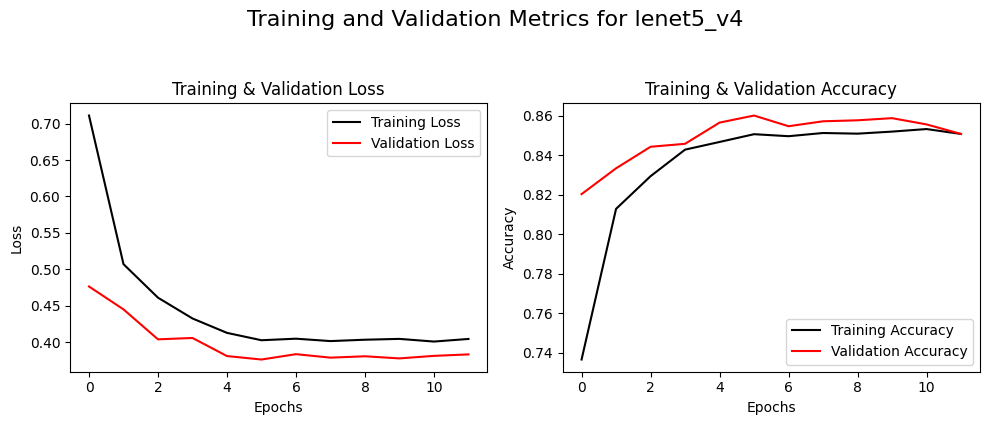

In [28]:
plot_train_val_metrics(history_lenet5_v4, "lenet5_v4")

In [42]:
export_model(model_lenet5_v4, 'lenet5_model_v4')

## Store results in CSV

In [ ]:
model_metrics = {
    'lenet5_model_original': {'train_loss': train_loss_v0, 'val_loss': val_loss_v0, 'train_acc': train_acc_v0, 'val_acc': val_acc_v0},
    'lenet5_model_v1': {'train_loss': train_loss_v1, 'val_loss': val_loss_v1, 'train_acc': train_acc_v1, 'val_acc': val_acc_v1},
    'lenet5_model_v2': {'train_loss': train_loss_v2, 'val_loss': val_loss_v2, 'train_acc': train_acc_v2, 'val_acc': val_acc_v2},
    'lenet5_model_v3': {'train_loss': train_loss_v3, 'val_loss': val_loss_v3, 'train_acc': train_acc_v3, 'val_acc': val_acc_v3},
    'lenet5_model_v4': {'train_loss': train_loss_v4, 'val_loss': val_loss_v4, 'train_acc': train_acc_v4, 'val_acc': val_acc_v4},
}

In [ ]:
def create_csv(model_metrics, filename):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the header
        header = ['Model', 'Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy']
        writer.writerow(header)

        # Write the data for each model
        for model_name, metrics in model_metrics.items():
            row = [
                model_name,
                metrics['train_loss'],
                metrics['val_loss'],
                metrics['train_acc'].item() if torch.is_tensor(metrics['train_acc']) else metrics['train_acc'],
                metrics['val_acc'].item() if torch.is_tensor(metrics['val_acc']) else metrics['val_acc']
            ]
            writer.writerow(row)

create_csv(model_metrics, 'final_model_metrics.csv')

## Test the model with the highest Validation Accuracy

In [68]:
results = pd.read_csv('final_model_metrics.csv')

# Find the id of the model with the max Validation Accuracy
max_val_acc_id = results['Validation Accuracy'].idxmax()

# Retrieve the row of this specific model
max_model = results.loc[max_val_acc_id]

max_val_acc_formatted = float("{:.3f}".format(max_model["Validation Accuracy"])) *100

print(f'The model with the highest Validation Accuracy ({max_val_acc_formatted}%) is {max_model["Model"]}')

The model with the highest Validation Accuracy (85.2%) is lenet5_model_original


In [69]:
results

,Model,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy
0,lenet5_model_original,0.358916,0.401943,0.865500,0.852417
1,lenet5_model_v1,0.415651,0.457803,0.843708,0.828750
2,lenet5_model_v2,0.572509,0.501463,0.783354,0.810333
3,lenet5_model_v3,0.482273,0.441005,0.819042,0.838417
4,lenet5_model_v4,0.485095,0.455255,0.819313,0.835417


In [82]:
max_model['Model']

'lenet5_model_original'

In [88]:
test_loss, test_acc = 0, 0
model_file = f"models/{max_model['Model']}.pt"

# Load the PyTorch model
model = torch.jit.load(model_file)

model.eval()
with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred, _, _ = model(X)

        test_loss += loss_fn(y_pred, y)
        test_acc += accuracy(y_pred, y)

    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

print(f"Test loss: {test_loss: .5f}| Test acc: {test_acc: .5f}")

Test loss:  0.32846| Test acc:  0.87849
